In [ ]:
 
#basic libs
import numpy as np
import pandas as pd
 
#visualization libs
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
#from jupyterthemes import jtplot
#jtplot.style(theme="monokai",context="notebook",ticks=True,grid=True)
 
#warnings
import warnings
warnings.filterwarnings("ignore")
 
#deep learning libs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Activation
 
#nlp libs
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.util import *
 
#preprocessing and metrics
from sklearn import metrics,preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
#deep learning libs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Activation
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the datasets**

In [ ]:

#loading the bse sensex  data
df_stock=pd.read_csv("/content/drive/MyDrive/stock/RS.csv")
#loading the news headlines related to the company
df_news=pd.read_csv("/content/drive/MyDrive/stock/india-news-headlines.csv")

In [ ]:
#displaying the stock prices
df_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,12.4375,12.46875,12.00000,12.06250,8.879863,28200
1,2001-01-03,12.0625,12.50000,12.00000,12.25000,9.017892,29400
2,2001-01-04,12.2500,12.31250,12.15625,12.25000,9.017892,17800
3,2001-01-05,12.1875,12.18750,11.75000,11.78125,8.672821,35600
4,2001-01-08,11.7500,11.81250,11.68750,11.81250,8.695828,58600


In [ ]:
#displaying the news headlines
df_news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


# **Feature engineering** 

In [ ]:
#checking the dimensions of both the datasets
df_stock.shape,df_news.shape

((5031, 7), (3424067, 3))

In [ ]:
# dropping the duplicates
df_stock=df_stock.drop_duplicates()

#converting the date column in type "datetime" column
df_stock["Date"]=pd.to_datetime(df_stock["Date"]).dt.normalize()

#filtering the important columns required
df_stock=df_stock.filter(["Date","Open","High","Low","Close","Volume"])

#setting the "Date" as index
df_stock.set_index("Date",inplace=True)

#Sorting the data based on the index
df_stock=df_stock.sort_index(ascending=True,axis=0)

#viewing the dataset
df_stock

,Open,High,Low,Close,Volume
Date,,,,,
2001-01-02,12.437500,12.468750,12.000000,12.062500,28200
2001-01-03,12.062500,12.500000,12.000000,12.250000,29400
2001-01-04,12.250000,12.312500,12.156250,12.250000,17800
2001-01-05,12.187500,12.187500,11.750000,11.781250,35600
2001-01-08,11.750000,11.812500,11.687500,11.812500,58600
...,...,...,...,...,...
2020-12-23,118.089996,119.220001,117.930000,118.480003,173800
2020-12-24,119.010002,119.010002,117.260002,118.120003,67200
2020-12-28,118.970001,119.919998,118.139999,118.410004,144400


### **Stock news data**

In [ ]:
# dropping the duplicates
df_news=df_news.drop_duplicates()

#converting the publish_date column in type "datetime" column
df_news["publish_date"]=df_news["publish_date"].astype(str)
df_news["publish_date"]=df_news["publish_date"].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
df_news["publish_date"]=pd.to_datetime(df_news["publish_date"]).dt.normalize()

#fltering the important columns required
df_news=df_news.filter(["publish_date","headline_text"])

#grouping the news according to "Date"
df_news=df_news.groupby(["publish_date"])["headline_text"].apply(lambda x: ','.join(x)).reset_index()

#setting the "publish_Date" as index
df_news.set_index("publish_date",inplace=True)

#Sorting the data based on the index
df_news=df_news.sort_index(ascending=True,axis=0)

#viewing the dataset
df_news

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [ ]:
#concatinating
df=pd.concat([df_news,df_stock],axis=1)

#slicing from 2001-05-22 to 2020-12-31
df=df[pd.Timestamp('2001-05-22'):pd.Timestamp('2020-12-31')]

#dropping null values if anly
df.dropna(axis=0,inplace=True)

#viewing the dataset
df

,headline_text,Open,High,Low,Close,Volume
2001-05-22,"She turned and fought,Re-negotiation best: Des...",14.355000,14.450000,14.150000,14.150000,49800.0
2001-05-25,What Women Want,13.705000,13.775000,13.650000,13.775000,9400.0
2001-05-29,"US visit won't be piece of cake for Krishna,Cy...",13.775000,13.875000,13.645000,13.655000,48000.0
2001-05-30,"Demolition drive: Beware of lake encroachment,...",13.655000,13.660000,13.275000,13.565000,191400.0
2001-06-01,"Nepal's gripping tale of sorrow,Mujhe Kucch Ke...",13.725000,13.800000,13.630000,13.745000,33400.0
...,...,...,...,...,...,...
2020-12-23,"Sawmill in Makarpura GIDC gutted; none hurt,Ci...",118.089996,119.220001,117.930000,118.480003,173800.0
2020-12-24,How to set the mood for sex during cold winter...,119.010002,119.010002,117.260002,118.120003,67200.0
2020-12-28,Horoscope Today; 28 December 2020: Check astro...,118.970001,119.919998,118.139999,118.410004,144400.0
2020-12-29,Man recovers charred remains of 'thief' from h...,118.779999,119.589996,117.760002,118.169998,207300.0


**Calculating sentiment scores**

In [ ]:
#adding the sentiment columns
df["compound"]=""
df["negative"]=""
df["neutral"]=""
df["positive"]=""
df["positive"]=""
df

,headline_text,Open,High,Low,Close,Volume,compound,negative,neutral,positive
2001-05-22,"She turned and fought,Re-negotiation best: Des...",14.355000,14.450000,14.150000,14.150000,49800.0,,,,
2001-05-25,What Women Want,13.705000,13.775000,13.650000,13.775000,9400.0,,,,
2001-05-29,"US visit won't be piece of cake for Krishna,Cy...",13.775000,13.875000,13.645000,13.655000,48000.0,,,,
2001-05-30,"Demolition drive: Beware of lake encroachment,...",13.655000,13.660000,13.275000,13.565000,191400.0,,,,
2001-06-01,"Nepal's gripping tale of sorrow,Mujhe Kucch Ke...",13.725000,13.800000,13.630000,13.745000,33400.0,,,,
...,...,...,...,...,...,...,...,...,...,...
2020-12-23,"Sawmill in Makarpura GIDC gutted; none hurt,Ci...",118.089996,119.220001,117.930000,118.480003,173800.0,,,,
2020-12-24,How to set the mood for sex during cold winter...,119.010002,119.010002,117.260002,118.120003,67200.0,,,,
2020-12-28,Horoscope Today; 28 December 2020: Check astro...,118.970001,119.919998,118.139999,118.410004,144400.0,,,,
2020-12-29,Man recovers charred remains of 'thief' from h...,118.779999,119.589996,117.760002,118.169998,207300.0,,,,


In [ ]:
#calling the required libraries
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
#keeping track of the progress 
tqdm.pandas()
#instantiating the sentiment analyzer
sid=SentimentIntensityAnalyzer()
#calculating the sentiment scores
df["compound"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["compound"])
df["negative"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["neg"])
df["neutral"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["neu"])
df["positive"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["pos"])

  0%|          | 12/4922 [00:00<00:41, 119.19it/s]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


100%|██████████| 4922/4922 [10:53<00:00,  7.53it/s]


In [ ]:
#viewing the dataset
df

,headline_text,Open,High,Low,Close,Volume,compound,negative,neutral,positive
2001-05-22,"She turned and fought,Re-negotiation best: Des...",14.355000,14.450000,14.150000,14.150000,49800.0,-0.9907,0.134,0.800,0.066
2001-05-25,What Women Want,13.705000,13.775000,13.650000,13.775000,9400.0,0.0772,0.000,0.606,0.394
2001-05-29,"US visit won't be piece of cake for Krishna,Cy...",13.775000,13.875000,13.645000,13.655000,48000.0,-0.9382,0.079,0.849,0.072
2001-05-30,"Demolition drive: Beware of lake encroachment,...",13.655000,13.660000,13.275000,13.565000,191400.0,0.5707,0.070,0.853,0.077
2001-06-01,"Nepal's gripping tale of sorrow,Mujhe Kucch Ke...",13.725000,13.800000,13.630000,13.745000,33400.0,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...
2020-12-23,"Sawmill in Makarpura GIDC gutted; none hurt,Ci...",118.089996,119.220001,117.930000,118.480003,173800.0,-0.9995,0.117,0.804,0.078
2020-12-24,How to set the mood for sex during cold winter...,119.010002,119.010002,117.260002,118.120003,67200.0,-0.9966,0.080,0.857,0.063
2020-12-28,Horoscope Today; 28 December 2020: Check astro...,118.970001,119.919998,118.139999,118.410004,144400.0,-0.9997,0.125,0.792,0.083
2020-12-29,Man recovers charred remains of 'thief' from h...,118.779999,119.589996,117.760002,118.169998,207300.0,-0.9997,0.134,0.777,0.089


**Writing the finalized data to a disk**

In [ ]:

#dropping the headline_text because it's unwanted now
df.drop(["headline_text"],axis=1,inplace=True)
#displaying the data
df

,Open,High,Low,Close,Volume,compound,negative,neutral,positive
2001-05-22,14.355000,14.450000,14.150000,14.150000,49800.0,-0.9907,0.134,0.800,0.066
2001-05-25,13.705000,13.775000,13.650000,13.775000,9400.0,0.0772,0.000,0.606,0.394
2001-05-29,13.775000,13.875000,13.645000,13.655000,48000.0,-0.9382,0.079,0.849,0.072
2001-05-30,13.655000,13.660000,13.275000,13.565000,191400.0,0.5707,0.070,0.853,0.077
2001-06-01,13.725000,13.800000,13.630000,13.745000,33400.0,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...
2020-12-23,118.089996,119.220001,117.930000,118.480003,173800.0,-0.9995,0.117,0.804,0.078
2020-12-24,119.010002,119.010002,117.260002,118.120003,67200.0,-0.9966,0.080,0.857,0.063
2020-12-28,118.970001,119.919998,118.139999,118.410004,144400.0,-0.9997,0.125,0.792,0.083
2020-12-29,118.779999,119.589996,117.760002,118.169998,207300.0,-0.9997,0.134,0.777,0.089


In [ ]:
#writing it to the disk
df.to_csv("finalized_stock_data.csv")

**checking the finalized data**

In [ ]:
#shape
df.shape

(4922, 9)

In [ ]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4922 entries, 2001-05-22 to 2020-12-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      4922 non-null   float64
 1   High      4922 non-null   float64
 2   Low       4922 non-null   float64
 3   Close     4922 non-null   float64
 4   Volume    4922 non-null   float64
 5   compound  4922 non-null   float64
 6   negative  4922 non-null   float64
 7   neutral   4922 non-null   float64
 8   positive  4922 non-null   float64
dtypes: float64(9)
memory usage: 384.5 KB


In [ ]:
#checking for missing values
df.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
compound    0
negative    0
neutral     0
positive    0
dtype: int64

In [ ]:

#data description
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,4922.0,52.436906,27.842580,6.740,29.152499,53.310000,72.344999,1.226500e+02
High,4922.0,53.135659,28.091754,6.970,29.857500,53.949999,73.077502,1.230900e+02
Low,4922.0,51.710213,27.591934,6.575,28.541250,52.485001,71.610001,1.209200e+02
Close,4922.0,52.429516,27.834587,6.740,29.450000,53.229999,72.367503,1.226500e+02
Volume,4922.0,653245.611540,519352.389760,9400.000,338800.000000,526400.000000,823775.000000,5.155700e+06
compound,4922.0,-0.884967,0.431673,-1.000,-0.999800,-0.999200,-0.995000,1.000000e+00
negative,4922.0,0.125918,0.022928,0.000,0.112000,0.127000,0.141000,4.000000e-01
neutral,4922.0,0.788348,0.031575,0.000,0.768000,0.785000,0.806000,1.000000e+00
positive,4922.0,0.085742,0.018738,0.000,0.075000,0.085000,0.096000,6.000000e-01


# **EDA of the finalized stock data**

**Visualizing the opening and closing prices of the stock**

Text(0.5, 1.0, 'Closing prices')

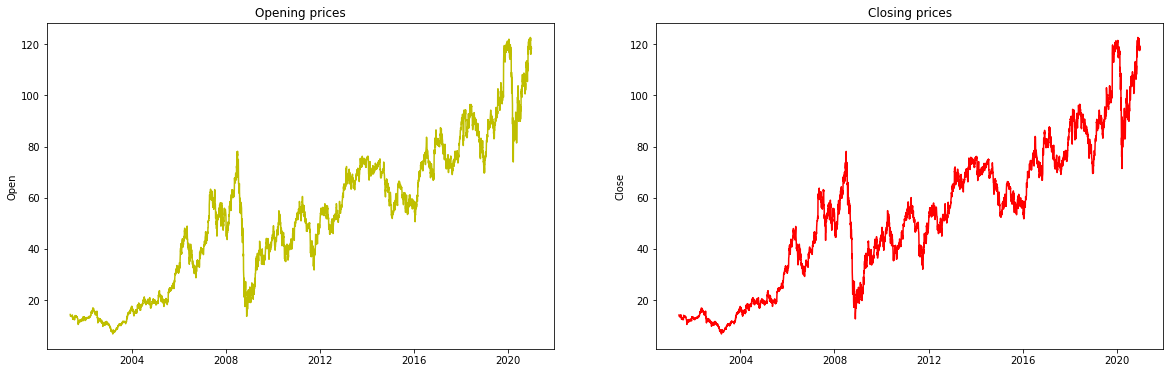

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=df,x=df.index,y="Open",ax=ax[0],color="y").set_title("Opening prices")
sns.lineplot(data=df,x=df.index,y="Close",ax=ax[1],color="r").set_title("Closing prices")


# **Data preprocessing for modelling**

In [ ]:
#splitting the data into input and target variables
x=df
y=df["Close"]
#splitting the data into train set and test set
training_set=x.iloc[:4000].values
test_set=x.iloc[4000:].values

In [ ]:

#scaling the input features with the help of standard scaler
sc=MinMaxScaler()
training_set_scaled=sc.fit_transform(training_set)
test_set_scaled=sc.fit_transform(test_set)

In [ ]:

# the model will look into past 100 timesteps predict the next feature and will continue to do so
length=100
#the training set creation
x_train=[]
y_train=[]
for i in range(length,len(training_set)):
    x_train.append(training_set_scaled[i-length:i,0])
    y_train.append(training_set_scaled[i,0])
#converting train set into array
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


# The testing set creation
x_test=[]
y_test=[]
for i in range(length,len(test_set)):
    x_test.append(test_set_scaled[i-length:i,0])
    y_test.append(test_set_scaled[i,0])
# converting test set into array
x_test,y_test=np.array(x_test),np.array(y_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
#checking the shape of the created datastructures
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((3900, 100, 1), (3900,), (822, 100, 1), (822,))

# **Modelling**

In [ ]:
# setting the model architecture
model=Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(x_train.shape[1], 1),activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True,activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=False,activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(1))
#printing model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [ ]:
# introducing early stopping if val loss doesn't go down for 4 iterations
es=EarlyStopping(monitor="val_loss",patience=4,mode="min")
#compiling
model.compile(optimizer="adam",loss="mse")
#fitting the model
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=22,shuffle=False,callbacks=[es])

Epoch 1/10
178/178 [==============================] - 50s 253ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 2/10
178/178 [==============================] - 44s 246ms/step - loss: 0.0018 - val_loss: 0.0069
Epoch 3/10
178/178 [==============================] - 44s 245ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 4/10
178/178 [==============================] - 44s 249ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 5/10
178/178 [==============================] - 44s 245ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 6/10
178/178 [==============================] - 43s 244ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 7/10
178/178 [==============================] - 44s 246ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 8/10
178/178 [==============================] - 44s 246ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 9/10
178/178 [==============================] - 44s 246ms/step - loss: 0.0013 - val_loss: 0.0030


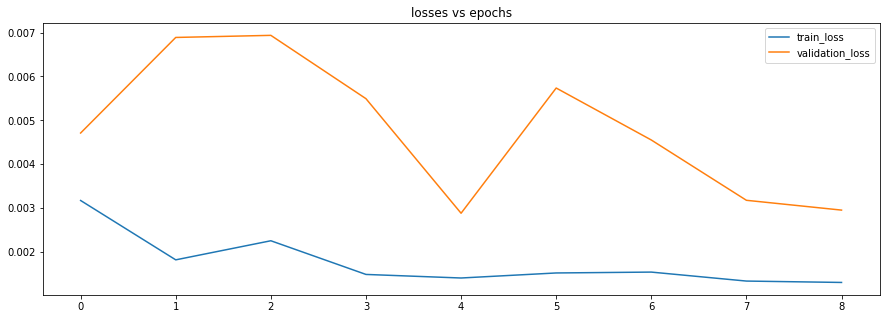

In [ ]:
#creating the dataframe contaning the validation loss and  train_inver_transform
loss=pd.DataFrame(model.history.history)
plt.figure(figsize=(15,5))
plt.plot(loss)
plt.title("losses vs epochs")
plt.legend(["train_loss","validation_loss"])

In [ ]:
#saving model to the disk as json file
model_json=model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

#serialize weights to HDF5
model.save_weights("model.h5")
print("model saved to the disk")

model saved to the disk


In [ ]:
#predicting through the model
pred=model.predict(x_test)

In [ ]:
#checking the scales and comparing it with our closing price column
sc.scale_,df_stock

(array([1.86532360e-02, 1.87969935e-02, 1.90621429e-02, 1.86776239e-02,
        5.66219353e-07, 5.00075011e-01, 7.63358779e+00, 7.19424460e+00,
        1.21951220e+01]),
                   Open        High         Low       Close  Volume
 Date                                                              
 2001-01-02   12.437500   12.468750   12.000000   12.062500   28200
 2001-01-03   12.062500   12.500000   12.000000   12.250000   29400
 2001-01-04   12.250000   12.312500   12.156250   12.250000   17800
 2001-01-05   12.187500   12.187500   11.750000   11.781250   35600
 2001-01-08   11.750000   11.812500   11.687500   11.812500   58600
 ...                ...         ...         ...         ...     ...
 2020-12-23  118.089996  119.220001  117.930000  118.480003  173800
 2020-12-24  119.010002  119.010002  117.260002  118.120003   67200
 2020-12-28  118.970001  119.919998  118.139999  118.410004  144400
 2020-12-29  118.779999  119.589996  117.760002  118.169998  207300
 2020-12-30  1

In [ ]:
# the 4th column is "close" so we should scale our values by the 4th value(corresponding value) in the scale array
scale=1/9.88704046e-03
#scaling the predicted values
pred=pred*scale
#scaling the test values
test=y_test*scale

In [ ]:
#creating the dataframe of test values vs predicted values
test_vs_pred=pd.DataFrame(columns=["test","pred"])
test_vs_pred["test"]=test
test_vs_pred["pred"]=pred.flatten()
#checking the dataframne created
test_vs_pred.head(10)

,test,pred
0,10.942473,11.648074
1,11.338680,11.985402
2,14.187489,12.401765
3,13.659233,13.613659
4,13.659233,14.864287
5,17.319309,15.683619
6,16.300524,17.096912
7,16.168461,18.284420
8,15.753398,18.874111
9,13.715830,18.820690


Text(700, 22, 'MSE:30.24')

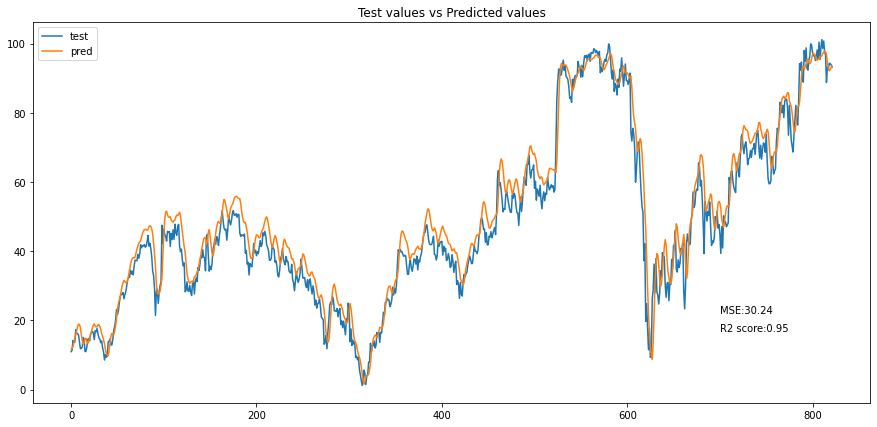

In [ ]:
#the lineplot
plt.figure(figsize=(15,7))
plt.plot(test_vs_pred)
plt.title("Test values vs Predicted values")
plt.legend(["test","pred"])
#calculating the losses
r2=np.round(r2_score(test,pred),2)
mse=np.round(mean_squared_error(test,pred),2)
#incorporating the losses in the plot
plt.text(x=700,y=17,s="R2 score:{}".format(r2))
plt.text(x=700,y=22,s="MSE:{}".format(mse))